Dickey Fuller Test

In [6]:
from __future__ import print_function
import statsmodels.tsa.stattools as ts
from datetime import datetime
import yfinance as yf

# Download the Amazon OHLCV data from 1/1/2000 to 1/1/2015
amzn = yf.download("AMZN", start="2000-01-01", end="2015-01-01")

# Output the results of the Augmented Dickey-Fuller test for Amazon
# with a lag order value of 1
result = ts.adfuller(amzn['Adj Close'], maxlag=1)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value {}: {:.3f}'.format(key, value))



[*********************100%%**********************]  1 of 1 completed


ADF Statistic: 0.049177549192430524
p-value: 0.9624149443695204
Critical Value 1%: -3.432
Critical Value 5%: -2.862
Critical Value 10%: -2.567


Hurst Component

In [9]:
from __future__ import print_function
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import yfinance as yf
from datetime import datetime

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

# Create a Geometric Brownian Motion, Mean-Reverting, and Trending Series
gbm = log(cumsum(randn(100000)) + 1000)
mr = log(randn(100000) + 1000)
tr = log(cumsum(randn(100000) + 1) + 1000)

# Output the Hurst Exponent for each of the above series
print("Hurst(GBM): %s" % hurst(gbm))
print("Hurst(MR): %s" % hurst(mr))
print("Hurst(TR): %s" % hurst(tr))

# Download the Amazon OHLCV data from 1/1/2000 to 1/1/2015 using yfinance
amzn = yf.download("AMZN", start="2000-01-01", end="2015-01-01")

# Output the Hurst Exponent for Amazon's Adjusted Close price
print("Hurst(AMZN): %s" % hurst(amzn['Adj Close']))


Hurst(GBM): 0.498778295196493
Hurst(MR): -0.00011931522149241567
Hurst(TR): 0.9557900530758779


[*********************100%%**********************]  1 of 1 completed


Hurst(AMZN): nan


/tmp/ipykernel_6050/803666220.py:14: RuntimeWarning: divide by zero encountered in log
  poly = polyfit(log(lags), log(tau), 1)


Cointegration

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


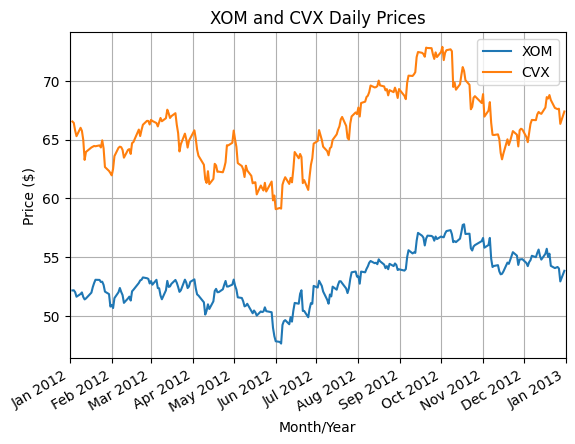

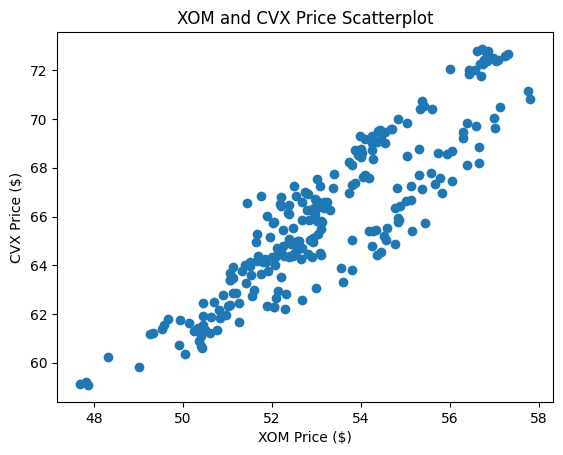

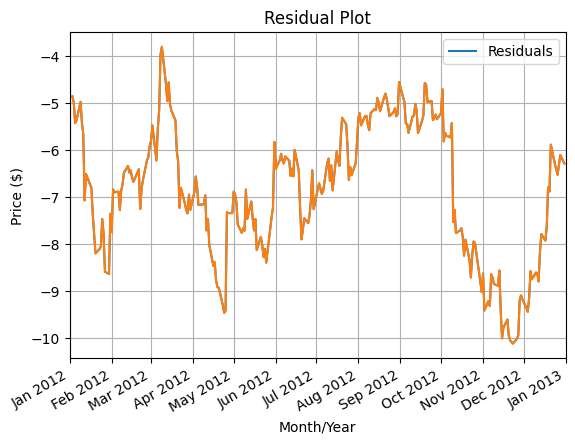

(-2.4541739971266074,
 0.1270260097066988,
 1,
 248,
 {'1%': -3.4569962781990573,
  '10%': -2.573018897632674,
  '5%': -2.8732659015936024},
 289.2892199362902)


In [13]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import yfinance as yf
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

def plot_price_series(df, ts1, ts2):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title(f'{ts1} and {ts2} Daily Prices')
    plt.legend()
    plt.show()

def plot_scatter_series(df, ts1, ts2):
    plt.xlabel(f'{ts1} Price ($)')
    plt.ylabel(f'{ts2} Price ($)')
    plt.title(f'{ts1} and {ts2} Price Scatterplot')
    plt.scatter(df[ts1], df[ts2])
    plt.show()

def plot_residuals(df):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(datetime.datetime(2012, 1, 1), datetime.datetime(2013, 1, 1))
    ax.grid(True)
    fig.autofmt_xdate()
    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(df["res"])
    plt.show()

if __name__ == "__main__":
    start = datetime.datetime(2012, 1, 1)
    end = datetime.datetime(2013, 1, 1)
    
    # Replace AREX and WLL with XOM and CVX (ExxonMobil and Chevron)
    xom = yf.download("XOM", start=start, end=end)
    cvx = yf.download("CVX", start=start, end=end)

    # Check if data was fetched correctly
    if xom.empty or cvx.empty:
        raise ValueError("Failed to fetch data for XOM or CVX. The DataFrame is empty.")

    df = pd.DataFrame(index=xom.index)
    df["XOM"] = xom["Adj Close"]
    df["CVX"] = cvx["Adj Close"]
    
    # Plot the two time series
    plot_price_series(df, "XOM", "CVX")
    
    # Display a scatter plot of the two time series
    plot_scatter_series(df, "XOM", "CVX")
    
    # Calculate optimal hedge ratio "beta"
    X = sm.add_constant(df["XOM"])
    model = sm.OLS(df["CVX"], X).fit()
    beta_hr = model.params["XOM"]
    
    # Calculate the residuals of the linear combination
    df["res"] = df["CVX"] - beta_hr * df["XOM"]
    
    # Plot the residuals
    plot_residuals(df)
    
    # Calculate and output the CADF test on the residuals
    cadf = ts.adfuller(df["res"])
    pprint.pprint(cadf)
